# Parameter sweep analysis using the WaterTAP `ParameterSweep` Tool  

The `ParameterSweep` tool is an analysis tool that is built into WaterTAP to allow users to sweep across model parameters or decision variables values in an existing WaterTAP model and analyze the impact on the cost and/or performance. 
In this demonstration, we will use the RO with ERD flowsheet developed in a previous sessions to perform the parameter sweep across different variables and investigate the impact on technoeconomic metrics.

## What You Will Learn

In this tutorial, you will learn:

1. **Manual Parameter Sweep**: How to implement a basic parameter sweep without using the WaterTAP tool (for understanding the underlying process)
2. **Building Parameter Sweep Functions**: How to structure three key functions required by the parameter sweep tool:
   - Model build and solve function
   - Sweep outputs function (defining what to record)
   - Sweep inputs function (defining parameters to vary)
3. **Single Parameter Sweeps**: How to perform parameter sweeps for a single variable (e.g., water recovery or membrane permeability)
4. **Multi-Parameter Sweeps**: How to simultaneously vary two parameters (e.g., pressure and membrane area)

# Imports

We will import our working flowsheet from an existing Python file that contains all the functions necessary to build, set operating conditions, scale, initialize, and solve our model.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from pyomo.environ import Objective, value, units as pyunits
from watertap.core.solvers import get_solver

# Import parameter sweep functions
from parameter_sweep import (
    LinearSample,
    parameter_sweep,
)

# Import existing flowsheet module
import RO_with_ERD as ro_erd

solver = get_solver()

# RO with ERD flowsheet

Here we are ensuring that we have working flowsheet and saving our base case results.

<center><img src="graphics/RO_with_ERD.png" width="600" /></center>


In [3]:
def build_and_solve():

    m = ro_erd.build()
    ro_erd.scale_system(m)
    ro_erd.add_costing(m)
    ro_erd.initialize_system(m)
    _ = ro_erd.solve_system(m)
    clear_output(wait=False)

    return m


m = build_and_solve()

In [10]:
# Save base case results
base_lcow = value(m.fs.costing.LCOW)
base_recovery = value(m.fs.RO.recovery_vol_phase[0, "Liq"])

base_A_comp = value(
    pyunits.convert(
        m.fs.RO.A_comp[0, "H2O"],
        to_units=pyunits.liter / pyunits.m**2 / pyunits.hour / pyunits.bar,
    )
)
base_mem_area = value(m.fs.RO.area)
base_pressure = value(
    pyunits.convert(
        m.fs.pump.control_volume.properties_out[0].pressure, to_units=pyunits.bar
    )
)

# Display base case results
print(f"\nBase LCOW: {base_lcow:.2f} $/m3")
print(f"Base Recovery: {base_recovery:.2f}")
print(f"\nBase A_comp: {base_A_comp:.2f} L/m2-hr-bar")
print(f"Base Membrane Area: {base_mem_area:.2f} m2")
print(f"Base Pump Outlet Pressure: {base_pressure:.2f} bar")


Base LCOW: 0.70 $/m3
Base Recovery: 0.75

Base A_comp: 1.51 L/m2-hr-bar
Base Membrane Area: 50.00 m2
Base Pump Outlet Pressure: 120.92 bar


# Sweeping across parameters *without* the ParameterSweep tool

The `ParameterSweep` tool essentially sweeps across parameter values provided by the user. We could also do this without the `ParameterSweep` tool where the model is run in a serial fashion at each parameter value. (This is demonstrated in the section below) 
However, the key steps to perform a parameter sweep remain the same in both approaches. The steps required include:

1. Define parameter space to be swept
2. Define the results to store
3. Create an initial instance of the model
4. Unfix design variables (if necessary)
5. Fix sweep variables to sweep value and solve model

### Step 1: Define parameter space to be swept

In this example we are sweeping across water recoveries 10-75%

In [4]:
# Define number of samples and parameter ranges
num_samples = 10
# Recovery range
recoveries = np.linspace(0.1, 0.75, num_samples)

### Step 2: Define the results to store

In this example, we are creating empty lists to save the model outputs

In [5]:
# Create lists to store results
lcow_results_list = list()
pressure_results_list = list()

### Step 3: Create an initial instance of the model

Here, we can use the `build_and_solve` we defined earlier in this Jupyter Notebook

In [6]:
# Create an initial instance of the model
m = build_and_solve()

### Step 4: Unfix design variables (if necessary)

Currently water recovery is fixed, but varying recovery will affect design. We assume the length of the membrane is fixed to our initial design  and unfix pump pressure to see how it changes with recovery

In [7]:
# Unfix variables to perform the sweep
m.fs.pump.control_volume.properties_out[0].pressure.unfix()
m.fs.RO.length.fix()

### Step 5: Fix sweep variables to sweep value and solve model

In [8]:
# Perform serial sweep over recovery values
for recovery in recoveries:
    # Fix water recovery
    m.fs.RO.recovery_vol_phase[0, "Liq"].fix(recovery)
    results = ro_erd.solve_system(m)

    # Add the LCOW and pressure to the lcow and pressure results lists
    lcow_results_list.append(value(m.fs.costing.LCOW))
    pressure_results_list.append(
        value(
            pyunits.convert(
                m.fs.pump.control_volume.properties_out[0].pressure,
                to_units=pyunits.bar,
            )
        )
    )

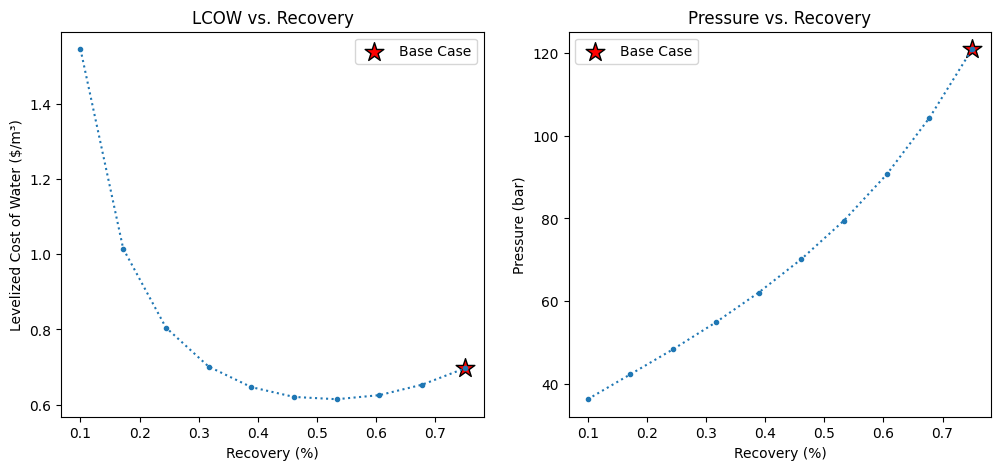

In [11]:
from plot_functions import plot_sweep_results

plot_sweep_results(
    recoveries,
    lcow_results_list,
    pressure_results_list,
    base_recovery,
    base_lcow,
    base_pressure,
)

# Using the `ParameterSweep` tool in WaterTAP

A primary advantage to using the parameter sweep tool over the serial sweep demonstration in the previous cell is the ability to run more samples quickly. In the section below, we will walk through how to use the `ParameterSweep` tool. 

The `ParameterSweep` function in WaterTAP requires the following functions as input.

1. `build_model`: A function that builds, scales, initializes, and solves an initial flowsheet. Importantly, this function *must return the model*.
2. `build_sweep_params`: A function that returns the desired sweep parameters
3. `build_outputs`: A function that returns a dictionary of desired model outputs


## 1. Model Build Function (`build_and_solve`)

Here we can use the same function `build_and_solve`  we used above. However, we add lines to fix/unfix the variables necessary to perform our sweep.  
 
In this case, we will fix the system design by fixing the membrane length to the value calculated after the initial solve.  

We will then unfix pump outlet pressure to explore how it varies when sweeping across water recoveries.

In [12]:
def build_and_solve():
    """
    Build and solve the RO with ERD model.
    """
    m = ro_erd.build()
    ro_erd.scale_system(m)
    ro_erd.add_costing(m)
    ro_erd.initialize_system(m)
    _ = ro_erd.solve_system(m)
    clear_output(wait=False)

    # Set system design by fixing membrane length
    m.fs.RO.length.fix(value(m.fs.RO.length))
    # Unfix pump outlet pressure for parameter sweep
    m.fs.pump.control_volume.properties_out[0].pressure.unfix()

    return m

## 2. Sweep Parameters Function (`build_sweep_params`)

The first positional argument to this function must be the model and must return the dictionary of sweep parameter values.

A built-in sampling function `LinearSample` was used to define the range and number of values for the variable `m.fs.RO.recovery_vol_phase`. This function requires the inputs:
1. Variable to swept across. In this example, `m.fs.RO.recovery_vol_phase`
2. The lower limit
3. The upper limit
4. Number of samples

NOTE: Other built-in sampling methods can be used such as Geometric, Normal etc.

In [13]:
def build_sweep_params(m, num_samples=10):

    sweep_params = {}
    sweep_params["Water Recovery"] = LinearSample(
        m.fs.RO.recovery_vol_phase, 0.1, 0.75, num_samples
    )
    return sweep_params

## 3. Outputs Function (`build_outputs`)

The first positional argument to this function must be the model and must return the output dictionary.  

We create an empty dictionary and then add key/value pairs that correspond to the specific model outputs we want.   

In this example, we are interested in the LCOW, LCOW breakdowns, and SEC.

NOTE: The key must be a string, and the value must be a Pyomo modeling object (e.g., `Var`, `Expression`, etc.)

In [14]:
def build_outputs(m):
    """
    Create dictionary of outputs to record from the model.
    """
    outputs = {}

    outputs["Total Capital Cost"] = m.fs.costing.total_capital_cost
    outputs["Total Operating Cost"] = m.fs.costing.total_operating_cost
    outputs["LCOW"] = m.fs.costing.LCOW
    outputs["SEC"] = m.fs.costing.SEC

    # Unit-level outputs
    outputs["Pressure"] = m.fs.pump.control_volume.properties_out[0].pressure
    outputs["Recovery"] = m.fs.RO.recovery_vol_phase[0, "Liq"]
    outputs["Membrane Area"] = m.fs.RO.area
    outputs["Membrane Permeability"] = m.fs.RO.A_comp[0, "H2O"]

    # LCOW components
    outputs["LCOW Direct CAPEX Pump"] = m.fs.costing.LCOW_component_direct_capex[
        "fs.pump"
    ]
    outputs["LCOW Indirect CAPEX Pump"] = m.fs.costing.LCOW_component_indirect_capex[
        "fs.pump"
    ]
    outputs["LCOW Direct CAPEX ERD"] = m.fs.costing.LCOW_component_direct_capex[
        "fs.erd"
    ]
    outputs["LCOW Indirect CAPEX ERD"] = m.fs.costing.LCOW_component_indirect_capex[
        "fs.erd"
    ]
    outputs["LCOW Direct CAPEX RO"] = m.fs.costing.LCOW_component_direct_capex["fs.RO"]
    outputs["LCOW Indirect CAPEX RO"] = m.fs.costing.LCOW_component_indirect_capex[
        "fs.RO"
    ]
    outputs["LCOW Fixed OPEX Pump"] = m.fs.costing.LCOW_component_fixed_opex["fs.pump"]
    outputs["LCOW Fixed OPEX RO"] = m.fs.costing.LCOW_component_fixed_opex["fs.RO"]
    outputs["LCOW Fixed OPEX ERD"] = m.fs.costing.LCOW_component_fixed_opex["fs.erd"]
    outputs["LCOW Variable OPEX Electricity"] = (
        m.fs.costing.LCOW_aggregate_variable_opex["electricity"]
    )
    return outputs

## 4. Run the parameter sweep

We can now pass these different functions to the `parameter_sweep` function to run. In addition to the functions we define above the `ParameterSweep` function also requires:

1. `build_sweep_params_kwargs`: This is a dictionary of the input arguments to the `build_sweep_params` function
2. `csv_results_file_name`: This is the name of the file when the output list we defined will be saved

In [81]:
num_samples = 10
file_save = "one_parameter_sweep_results.csv"

results_array, results_dict = parameter_sweep(
    build_model=build_and_solve,
    build_sweep_params=build_sweep_params,
    build_sweep_params_kwargs={"num_samples": num_samples},
    build_outputs=build_outputs,
    csv_results_file_name=file_save,
)

Lets plot the results!

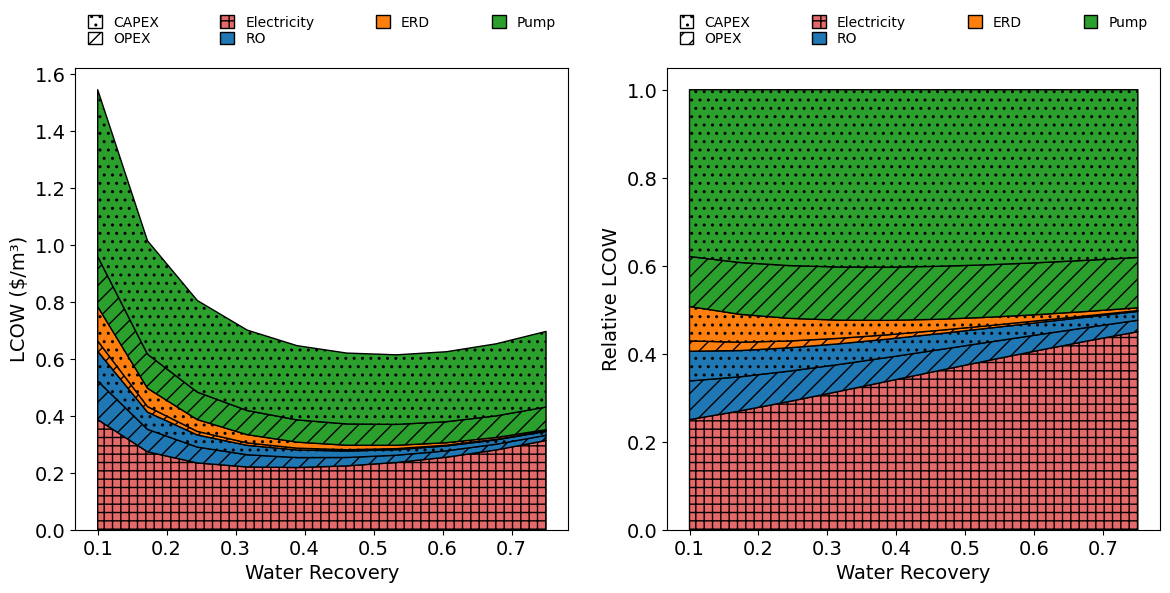

In [82]:
from plot_functions import make_stacked_plot

make_stacked_plot(file_name="one_parameter_sweep_results.csv")

# Two Parameter Sweep

We can also use the `ParameterSweep` tool to perform a two parameter sweep.  

In example below, we will unfix water recovery and sweep across:
1. Membrane area
2. Pump outlet pressure


In [ ]:
def build_and_solve():
    """
    Build and solve the RO with ERD model.
    """

    m = ro_erd.build()
    ro_erd.scale_system(m)
    ro_erd.add_costing(m)
    ro_erd.initialize_system(m)
    _ = ro_erd.solve_system(m)
    clear_output(wait=False)

    m.fs.RO.recovery_vol_phase.unfix()
    m.fs.obj = Objective(expr=m.fs.costing.LCOW)

    return m


def build_sweep_params(m, num_samples=10):

    sweep_params = {}
    sweep_params["Pressure"] = LinearSample(
        m.fs.pump.control_volume.properties_out[0].pressure, 60e5, 100e5, num_samples
    )
    sweep_params["Area"] = LinearSample(m.fs.RO.area, 25, 85, num_samples)

    return sweep_params


num_samples = 25
file_save = "two_parameter_sweep_results.csv"

results_array, results_dict = parameter_sweep(
    build_model=build_and_solve,
    build_sweep_params=build_sweep_params,
    build_sweep_params_kwargs={"num_samples": num_samples},
    build_outputs=build_outputs,
    num_samples=num_samples,
    csv_results_file_name=file_save,
)

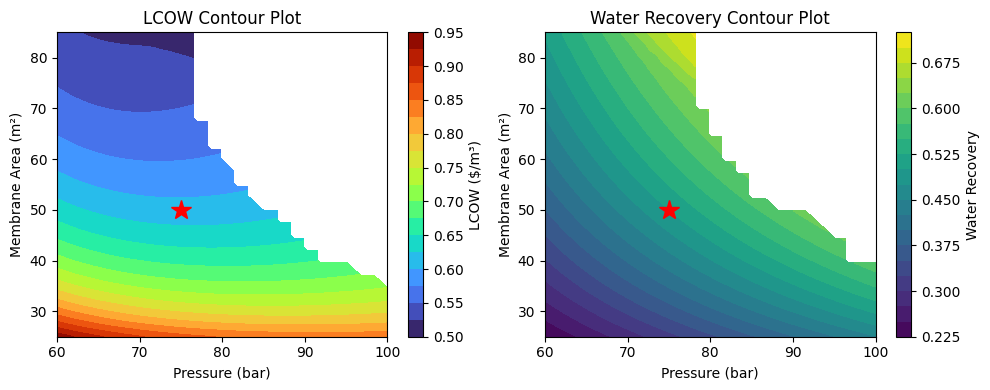

In [ ]:
from plot_functions import make_contour_plot

df = pd.read_csv("two_parameter_sweep_results.csv")

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# LCOW contour plot on left subplot
fig, axes[0] = make_contour_plot(
    df,
    x="# Pressure",
    y="Area",
    z="LCOW",
    x_adj=1e-5,
    set_dict={
        "xlabel": "Pressure (bar)",
        "ylabel": "Membrane Area (m²)",
        "title": "LCOW Contour Plot",
    },
    fig=fig,
    ax=axes[0],
)

# Recovery contour plot on right subplot
fig, axes[1] = make_contour_plot(
    df,
    x="# Pressure",
    y="Area",
    z="Recovery",
    x_adj=1e-5,
    cmap="viridis",
    set_dict={
        "xlabel": "Pressure (bar)",
        "ylabel": "Membrane Area (m²)",
        "title": "Water Recovery Contour Plot",
    },
    fig=fig,
    ax=axes[1],
    cb_title="Water Recovery",
)

# Plot the base case point
axes[0].plot([base_pressure], [base_mem_area], marker="*", color="red", markersize=15)
axes[1].plot([base_pressure], [base_mem_area], marker="*", color="red", markersize=15)

plt.tight_layout()
plt.show()

# Try It Yourself

Let's now run a single parameter sweep for membrane permeability.

- Create the `build_and_solve` function. The function should fix the membrane length and unfix the RO recovery.
- Create the `build_sweep_params` function and designate membrane permeability `m.fs.RO.A_comp` as a `LinearSample` from 1e-6 to 6e-6 m/s/Pa. This function should be able to accept a `number_samples` keyword argument.
- You can use the `build_outputs` function from previous examples in this tutorial.
- Run the parameter sweep for 50 samples.

<details>
  <summary>Click the arrow for hint #1!</summary>
    
To fix the membrane length use `m.fs.RO.length.fix(value(m.fs.RO.length))`.
To unfix the recovery use `m.fs.RO.recovery_vol_phase.unfix()`
</details>

<details>
  <summary>Click the arrow for hint #2!</summary>
    
`sweep_params["A_comp"] = LinearSample(m.fs.RO.A_comp, 1.0e-12, 6e-12, num_samples)`
</details>

In [19]:
def build_and_solve():
    """
    Build and solve the RO with ERD model.
    """
    m = ro_erd.build()
    ro_erd.scale_system(m)
    ro_erd.add_costing(m)
    ro_erd.initialize_system(m)
    _ = ro_erd.solve_system(m)
    clear_output(wait=False)

    # Set system design by fixing membrane length --> to be removed before merge
    m.fs.RO.length.fix(value(m.fs.RO.length))
    # Unfix recovery --> to be removed before merge
    m.fs.RO.recovery_vol_phase.unfix()

    return m


def build_sweep_params(m, num_samples=10):

    sweep_params = {}
    # Create sweep for membrane permeability --> to be removed before merge
    sweep_params["A_comp"] = LinearSample(m.fs.RO.A_comp, 1.0e-12, 6e-12, num_samples)
    return sweep_params


num_samples = 50
file_save = "tiy_parameter_sweep_results.csv"

results_array, results_dict = parameter_sweep(
    build_model=build_and_solve,
    build_sweep_params=build_sweep_params,
    build_sweep_params_kwargs={"num_samples": num_samples},
    build_outputs=build_outputs,
    num_samples=num_samples,
    csv_results_file_name=file_save,
)

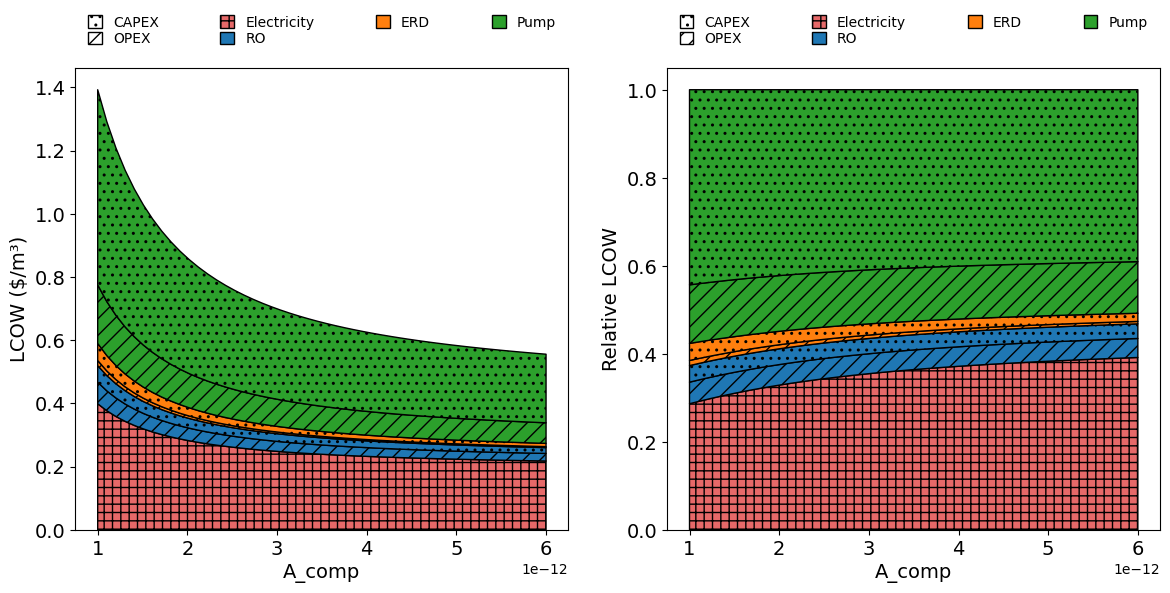

In [20]:
from plot_functions import make_stacked_plot

make_stacked_plot("tiy_parameter_sweep_results.csv", parameter="A_comp")

# Summary

## What We Covered

In this tutorial, we explored the WaterTAP parameter sweep tool for systematic analysis of RO desalination systems. Here's a recap of the key concepts and steps.  

The tool provides a structured, efficient approach requiring three key functions:

#### 1. Model Build Function (`build_and_solve`)
- Constructs the flowsheet
- Scales the system
- Adds costing
- Initializes and solves
- **Critical**: Sets which variables are fixed vs. free for the sweep
- Must return the model object

#### 2. Sweep Parameters Function (`build_sweep_params`)
- Specifies which variables to sweep and their ranges
- Uses `LinearSample` for uniform sampling
- Can accept kwargs like `num_samples` for flexibility
- Returns a dictionary of parameters to sweep

#### 3. Outputs Function (`build_outputs`)
- Defines a dictionary of results to record
- Keys are string names, values are Pyomo model components
- Can include costs, performance metrics, unit-level outputs
- Example outputs: LCOW, SEC, pressure, recovery, membrane area


### Single Parameter Sweep

We performed a one-dimensional sweep on water recovery:
- Explored recovery from 0.1 to 0.75
- Fixed membrane length to constrain design
- Unfixed pump pressure to see how it adjusts
- Visualized LCOW breakdown by component (CAPEX, OPEX, electricity)

### Two Parameter Sweep

We extended to two dimensions with pressure and membrane area:
- Created a grid of parameter combinations
- Added an optimization objective (minimize LCOW)
- Unfixed recovery to let the model minimize the LCOW
- Generated contour plots showing:
  - LCOW across the parameter space
  - Water recovery trends
  - Optimal operating regions

